# Instalación e Importación librerías Spark y PySpark

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 204.8MB 67kB/s 
     |████████████████████████████████| 204kB 50.3MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.2-py2.py3-none-any.whl size=205186687 sha256=54394651bff7677e29faf5492927e2e7dc58f2d582180f10ce244203de2e263a
  Stored in directory: /root/.cache/pip/wheels/8b/09/da/c1f2859bcc86375dc972c5b6af4881b3603269bcc4c9be5d16
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 10 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# Importamos los paquetes necesarios

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [ ]:
# Creamos la configuración de sesión
conf = SparkConf().set("spark.ui.port", "4050")

# creación del SparkContext
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder \
        .master("local") \
        .appName("Google colab - The Bridge") \
        .config("spark.ui.port", "4050") \
        .getOrCreate()

In [ ]:
# Para monitorizar al puerto 4050 de spark
#!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels

In [ ]:
# ejecutamos spark
spark

## Spark ML

![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) + ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png020
### Practica sobre cómo generar un flujo de ejecución en un problema de Machine Learning

Esta práctica simula un ejercicio completo de ETL (Extract-Transform-Load) junto a un análisis exploratorio de un dataset real, para posteriormente aplicar differentes algoritmos de aprendizaje automático que resuelvan un problema de regresión.

#### Contenido del ejercicio

* *Conocimiento del dominio*
* *Parte 1: Extracción, transformación y carga [ETL] del dataset* (2 punto sobre 10)
* *Parte 2: Explorar los datos* (2 puntos sobre 10)
* *Parte 3: Visualizar los datos* (2 puntos sobre 10)
* *Parte 4: Preparar los datos* (1 puntos sobre 10)
* *Parte 5: Modelar los datos* (3 puntos sobre 10)

*Nuestro objetivo será predecir de la forma más exacta posible la energía generada por un conjunto de plantas eléctricas usando los datos generados por un conjunto de sensores.*


## Conocimiento del dominio

### Background 

La generación de energía es un proceso complejo, comprenderlo para poder predecir la potencia de salida es un elemento vital en la gestión de una planta energética y su conexión a la red. Los operadores de una red eléctrica regional crean predicciones de la demanda de energía en base a la información histórica y los factores ambientales (por ejemplo, la temperatura). Luego comparan las predicciones con los recursos disponibles (por ejemplo, plantas, carbón, gas natural, nuclear, solar, eólica, hidráulica, etc). Las tecnologías de generación de energía, como la solar o la eólica, dependen en gran medida de las condiciones ambientales, pero todas las centrales eléctricas son objeto de mantenimientos tanto planificados y como puntuales debidos a un problema.

En esta practica usaremos un ejemplo del mundo real sobre la demanda prevista (en dos escalas de tiempo), la demanda real, y los recursos disponibles de la red electrica de California: http://www.caiso.com/Pages/TodaysOutlook.aspx

![](http://content.caiso.com/outlook/SP/ems_small.gif)

El reto para un operador de red de energía es cómo manejar un déficit de recursos disponibles frente a la demanda real. Hay tres posibles soluciones a un déficit de energía: construir más plantas de energía base (este proceso puede costar muchos anos de planificación y construcción), comprar e importar de otras redes eléctricas regionales energía sobrante (esta opción puede ser muy cara y está limitado por las interconexiones entre las redes de transmisión de energía y el exceso de potencia disponible de otras redes), o activar pequeñas [plantas de pico](https://en.wikipedia.org/wiki/Peaking_power_plant). Debido a que los operadores de red necesitan responder con rapidez a un déficit de energía para evitar un corte del suministro, estos basan sus decisiones en una combinación de las dos últimas opciones. En esta práctica, nos centraremos en la última elección.

### La lógica de negocio

Debido a que la demanda de energía solo supera a la oferta ocasionalmente, la potencia suministrada por una planta de energía pico tiene un precio mucho más alto por kilovatio hora que la energía generada por las centrales eléctricas base de una red eléctrica. Una planta pico puede operar muchas horas al día, o solo unas pocas horas al año, dependiendo de la condición de la red eléctrica de la región. Debido al alto coste de la construcción de una planta de energía eficiente, si una planta pico solo va a funcionar por un tiempo corto o muy variable, no tiene sentido económico para que sea tan eficiente como una planta de energía base. Además, el equipo y los combustibles utilizados en las plantas base a menudo no son adecuados para uso en plantas de pico.

La salida de potencia de una central eléctrica pico varía dependiendo de las condiciones ambientales, por lo que el problema de negocio a resolver se podría describir como _predecir la salida de potencia de una central eléctrica pico en función de la condiciones ambientales_  - ya que esto permitiría al operador de la red hacer compensaciones económicas sobre el número de plantas pico que ha de conectar en cada momento (o si por el contrario le interesa comprar energía más cara de otra red).

Una vez descrita esta lógica de negocio, primero debemos proceder a realizar un análisis exploratorio previo y trasladar el problema de negocio (predecir la potencia de salida en función de las condiciones medio ambientales) en un tarea de aprendizaje automático (ML). Por ejemplo, una tarea de ML que podríamos aplicar a este problema es la regresión, ya que tenemos un variable objetivo (dependiente) que es numérica. Para esto usaremos [Apache Spark ML Pipeline](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark-ml-package) para calcular dicha regresión.

Los datos del mundo real que usaremos en esta práctica se componen de 9.568 puntos de datos, cada uno con 4 atributos ambientales recogidos en una Central de Ciclo Combinado de más de 6 años (2006-2011), proporcionado por la Universidad de California, Irvine en [UCI Machine Learning Repository Combined Cycle Power Plant Data Set](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant)). Para más detalles sobre el conjunto de datos visitar la página de la UCI, o las siguientes referencias:

* Pinar Tufekci, [Prediction of full load electrical power output of a base load operated combined cycle power plant using machine learning methods](http://www.journals.elsevier.com/international-journal-of-electrical-power-and-energy-systems/), International Journal of Electrical Power & Energy Systems, Volume 60, September 2014, Pages 126-140, ISSN 0142-0615.
* Heysem Kaya, Pinar Tufekci and Fikret S. Gurgen: [Local and Global Learning Methods for Predicting Power of a Combined Gas & Steam Turbine](http://www.cmpe.boun.edu.tr/~kaya/kaya2012gasturbine.pdf), Proceedings of the International Conference on Emerging Trends in Computer and Electronics Engineering ICETCEE 2012, pp. 13-18 (Mar. 2012, Dubai).

In [ ]:
!wget https://github.com/marcusRB/The_Bridge_School_DataScience_PT/raw/main/99_Challenges/04_Challenge_Spark/data/challenge04.zip

In [ ]:
!unzip /content/challenge04.zip

In [ ]:
# Descomprimimos la carpeta pra2.zip
!unzip /content/pra2.zip

Archive:  /content/pra2.zip
   creating: pra2/
  inflating: pra2/sheet1.csv         
  inflating: pra2/sheet2.csv         
  inflating: pra2/sheet3.csv         
  inflating: pra2/sheet4.csv         
  inflating: pra2/sheet5.csv         


**Tarea a realizar durante la primera parte:**

Revisar la documentacion y referencias de:
* [Spark Machine Learning Pipeline](https://spark.apache.org/docs/latest/ml-guide.html#main-concepts-in-pipelines).

**Tarea a realizar durante la primera parte:**Revisar la documentacion y referencias de:
* [Spark Machine Learning Pipeline](https://spark.apache.org/docs/latest/ml-guide.html#main-concepts-in-pipelines).
19:06

## Parte 1: Extracción, transformación y carga [ETL] del dataset

Ahora que entendemos lo que estamos tratando de hacer, el primer paso consiste en cargar los datos en un formato que podemos consultar y utilizar fácilmente. Esto se conoce como ETL o "extracción, transformación y carga". Primero, vamos a cargar nuestro archivo de HDFS.Nuestros datos están disponibles en la siguiente ruta:

```
/carpeta-datos/pra2
```

### Ejercicio 1(a)

Empezaremos por visualizar una muestra de los datos. Para esto usaremos las funciones de hdfs para explorar el contenido del directorio de trabajo:/carpeta/datos/pra2

In [ ]:
# !hdfs dfs -ls /nombre-carpeta/data/pra2

/bin/bash: hdfs: command not found


Usar la función `cat` y `| head -10` para visualizar el contenido de las primeras 10 filas del primer fichero de la lista

In [ ]:
# !hdfs dfs -cat /content/pra2/sheet1.csv | head -10

/bin/bash: hdfs: command not found


==========================================================================================================================================================================================================
### Ejercicio 1(b)

Ahora usaremos PySpark para visualizar las 5 primeras líneas de los datos

*Hint*: Primero crea un RDD a partir de los datos usando [`sc.textFile()`](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.SparkContext.textFile).

*Hint*: Luego piensa como usar el RDD creado para mostrar datos, el método [`take()`](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.take) puede ser una buena opción a considerar.

In [ ]:
# # En modo cluster# 
sc = pyspark.SparkContext(master="local[1]", appName="pra2_mrusso")

In [ ]:
# sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
# Cargamos los ficheros y guardamos la variable
textosRDD = sc.textFile("/content/pra2")
print(textosRDD.take(5))

['AT,V,AP,RH,PE', '14.96,41.76,1024.07,73.17,463.26', '25.18,62.96,1020.04,59.08,444.37', '5.11,39.4,1012.16,92.14,488.56', '20.86,57.32,1010.24,76.64,446.48']


In [ ]:
# guardarmos el resultado
data = textosRDD
type(textosRDD)

pyspark.rdd.RDD

In [ ]:
data.take(20)

['AT,V,AP,RH,PE',
 '14.96,41.76,1024.07,73.17,463.26',
 '25.18,62.96,1020.04,59.08,444.37',
 '5.11,39.4,1012.16,92.14,488.56',
 '20.86,57.32,1010.24,76.64,446.48',
 '10.82,37.5,1009.23,96.62,473.9',
 '26.27,59.44,1012.23,58.77,443.67',
 '15.89,43.96,1014.02,75.24,467.35',
 '9.48,44.71,1019.12,66.43,478.42',
 '14.64,45,1021.78,41.25,475.98',
 '11.74,43.56,1015.14,70.72,477.5',
 '17.99,43.72,1008.64,75.04,453.02',
 '20.14,46.93,1014.66,64.22,453.99',
 '24.34,73.5,1011.31,84.15,440.29',
 '25.71,58.59,1012.77,61.83,451.28',
 '26.19,69.34,1009.48,87.59,433.99',
 '21.42,43.79,1015.76,43.08,462.19',
 '18.21,45,1022.86,48.84,467.54',
 '11.04,41.74,1022.6,77.51,477.2',
 '14.45,52.75,1023.97,63.59,459.85']

A partir nuestra exploración inicial de una muestra de los datos, podemos hacer varias observaciones sobre el proceso de ETL:
- Los datos son un conjunto de .csv (archivos con valores separados por coma) 
- Hay una fila de cabecera, que es el nombre de las columnas
- Parece que el tipo de los datos en cada columna es constante (es decir, cada columna es de tipo double)

El esquema de datos que hemos obtenido de UCI es:
- AT = Atmospheric Temperature in C
- V = Exhaust Vacuum Speed
- AP = Atmospheric Pressure
- RH = Relative Humidity
- PE = Power Output.  Esta es la variable dependiente que queremos predecir usando los otras cuatro

Para usar el paquete Spark CSV, usaremos el método [sqlContext.read.format()](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.format) para especificar el formato de la fuente de datos de entrada: `'csv'`

Podemos especificar diferentes opciones de como importar los datos usando el método [options()](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.options).

Usaremos las siguientes opciones:
- `delimiter=','` porque nuestros datos se encuentran delimitados por comas
- `header='true'` porque nuestro dataset tiene una fila que representa la cabecera de los datos
- `inferschema='true'` porque creemos que todos los datos son números reales, por lo tanto la librería puede inferir el tipo de cada columna de forma automática.

El ultimo componente necesario para crear un DataFrame es determinar la ubicación de los datos usando el método [load()](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.load).

Juntando todo, usaremos la siguiente operación:

`sqlContext.read.format().options().load()`

### Ejercicio 1(c)

Crear un DataFrame a partir de los datos.
- El formato es csv

En el campo opciones incluiremos 3, formadas por nombre de opción y valor, separadas por coma.
- El separador es el tabulador
- El fichero contiene cabecera 'header'
- Para crear un dataframe necesitamos un esquema (schema). A partir de los datos Spark puede tratar de inferir el esquema, le diremos 'true'.

El directorio a cargar es el especificado anteriormente. Es importante indicarle a Spark que es una ubicación ya montada en el sistema dbfs, como se ha mostrado en el ejercicio 2a.

In [ ]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [ ]:
# Creamos el dataframe
powerPlantDF = sqlContext.read.format('csv').options(delimiter=',',
                                                     header='true',
                                                     inferschema='true').load('/content/pra2/*.csv')

In [ ]:
type(powerPlantDF)

pyspark.sql.dataframe.DataFrame

In [ ]:
# Contamos cuantos datos tenemos en nuestro dataframe
powerPlantDF.count()

47840

In [ ]:
# TEST
expected = set([(s, 'double') for s in ('AP', 'AT', 'PE', 'RH', 'V')])
assert expected==set(powerPlantDF.dtypes), "Incorrect schema for powerPlantDF"

In [ ]:
# Comprobamos los tipos de valores
print(powerPlantDF.dtypes)

[('AT', 'double'), ('V', 'double'), ('AP', 'double'), ('RH', 'double'), ('PE', 'double')]


In [ ]:
# Para mostrar el dataframe
powerPlantDF.head(10)

[Row(AT=14.96, V=41.76, AP=1024.07, RH=73.17, PE=463.26),
 Row(AT=25.18, V=62.96, AP=1020.04, RH=59.08, PE=444.37),
 Row(AT=5.11, V=39.4, AP=1012.16, RH=92.14, PE=488.56),
 Row(AT=20.86, V=57.32, AP=1010.24, RH=76.64, PE=446.48),
 Row(AT=10.82, V=37.5, AP=1009.23, RH=96.62, PE=473.9),
 Row(AT=26.27, V=59.44, AP=1012.23, RH=58.77, PE=443.67),
 Row(AT=15.89, V=43.96, AP=1014.02, RH=75.24, PE=467.35),
 Row(AT=9.48, V=44.71, AP=1019.12, RH=66.43, PE=478.42),
 Row(AT=14.64, V=45.0, AP=1021.78, RH=41.25, PE=475.98),
 Row(AT=11.74, V=43.56, AP=1015.14, RH=70.72, PE=477.5)]

In [ ]:
# mostramos los 10 primeros resultados o show() los primeros 20
powerPlantDF.show(10)

+-----+-----+-------+-----+------+
|   AT|    V|     AP|   RH|    PE|
+-----+-----+-------+-----+------+
|14.96|41.76|1024.07|73.17|463.26|
|25.18|62.96|1020.04|59.08|444.37|
| 5.11| 39.4|1012.16|92.14|488.56|
|20.86|57.32|1010.24|76.64|446.48|
|10.82| 37.5|1009.23|96.62| 473.9|
|26.27|59.44|1012.23|58.77|443.67|
|15.89|43.96|1014.02|75.24|467.35|
| 9.48|44.71|1019.12|66.43|478.42|
|14.64| 45.0|1021.78|41.25|475.98|
|11.74|43.56|1015.14|70.72| 477.5|
+-----+-----+-------+-----+------+
only showing top 10 rows



Ahora en lugar de usar [spark csv](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html) para inferir (inferSchema()) los tipos de las columnas, especificaremos el esquema como [DataType](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.types.DataType), el cual es una lista de [StructField](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.types.StructType).

La lista completa de tipos se encuentra en el modulo [pyspark.sql.types](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.types). Para nuestros datos, usaremos [DoubleType()](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.types.DoubleType).

Por ejemplo, para especificar cual es el nombre de la columna usaremos: `StructField(`_name_`,` _type_`, True)`. (El tercer parámetro, `True`, significa que permitimos que la columna tenga valores null.)

### Ejercicio 1(d)

Crea un esquema a medida para el dataset.

In [ ]:
# para crear un nuevo schema importamos los métodos de los tipos
from pyspark.sql.types import *

# construimos el schema
customSchema = StructType([ \
    StructField('AT', DoubleType(), True), \
    StructField('V', DoubleType(), True), \
    StructField('AP', DoubleType(), True), \
    StructField('RH', DoubleType(), True), \
    StructField('PE', DoubleType(), True)])

In [ ]:
# TEST
assert set([f.name for f in customSchema.fields])==set(['AT', 'V', 'AP', 'RH', 'PE']), 'Incorrect column names in schema.'
assert set([f.dataType for f in customSchema.fields])==set([DoubleType(), DoubleType(), DoubleType(), DoubleType(), DoubleType()]), 'Incorrect column types in schema.'

### Exercicio 1(e)

Ahora, usaremos el esquema que acabamos de crear para leer los datos. Para realizar esta operación, modificaremos el paso anterior `sqlContext.read.format`. Podemos especificar el esquema haciendo:
- Anadir `schema = customSchema` al método load (simplemente anadelo usando una coma justo después del nombre del archivo)
- Eliminado la opción `inferschema='true'` ya que ahora especificamos el esquema que han de seguir los datos

In [ ]:
# creamos el dataframe con un customSchema
alt_powerPlantDF = sqlContext.read.format('csv') \
  .options(delimiter=',', header='true') \
  .schema(customSchema) \
  .load('/content/pra2/*.csv')

In [ ]:
alt_powerPlantDF.show(10)

+-----+-----+-------+-----+------+
|   AT|    V|     AP|   RH|    PE|
+-----+-----+-------+-----+------+
|14.96|41.76|1024.07|73.17|463.26|
|25.18|62.96|1020.04|59.08|444.37|
| 5.11| 39.4|1012.16|92.14|488.56|
|20.86|57.32|1010.24|76.64|446.48|
|10.82| 37.5|1009.23|96.62| 473.9|
|26.27|59.44|1012.23|58.77|443.67|
|15.89|43.96|1014.02|75.24|467.35|
| 9.48|44.71|1019.12|66.43|478.42|
|14.64| 45.0|1021.78|41.25|475.98|
|11.74|43.56|1015.14|70.72| 477.5|
+-----+-----+-------+-----+------+
only showing top 10 rows



In [ ]:
print(alt_powerPlantDF.dtypes)

[('AT', 'double'), ('V', 'double'), ('AP', 'double'), ('RH', 'double'), ('PE', 'double')]


## Parte 2: Explorar tus Datos

### Ejercicio 2(a)

​

Ahora que ya hemos cargado los datos, el siguiente paso es explorarlos y realizar algunos análisis y visualizaciones básicas.

​

Este es un paso que siempre se debe realizar **antes de** intentar ajustar un modelo a los datos, ya que este paso muchas veces nos permitirá conocer una gran información sobre los datos.

En primer lugar vamos a registrar nuestro DataFrame como una tabla de SQL llamado power_plant. Debido a que es posible que repitas esta práctica varias veces, vamos a tomar la precaución de eliminar cualquier tabla existente en primer lugar.

Una vez ejecutado el paso anterior, podemos registrar nuestro DataFrame como una tabla de SQL usando sqlContext.registerDataFrameAsTable().

Crea una tabla llamada power_plant con las indicaciones mostradas.


In [ ]:
sqlContext.registerDataFrameAsTable(alt_powerPlantDF, "power_plant")

In [ ]:
# Para poder realizar consultas utilizamos queries de SQL
sqlContext.sql("SELECT * FROM power_plant")

DataFrame[AT: double, V: double, AP: double, RH: double, PE: double]

Ahora que nuestro DataFrame existe como una tabla SQL, podemos explorarlo utilizando comandos SQL y `sqlContext.sql(...)`. Utiliza la función `show()` para visualizar el resultado del dataframe.

In [ ]:
dfAll = sqlContext.sql("SELECT * FROM power_plant")
dfAll.show()

+-----+-----+-------+-----+------+
|   AT|    V|     AP|   RH|    PE|
+-----+-----+-------+-----+------+
|14.96|41.76|1024.07|73.17|463.26|
|25.18|62.96|1020.04|59.08|444.37|
| 5.11| 39.4|1012.16|92.14|488.56|
|20.86|57.32|1010.24|76.64|446.48|
|10.82| 37.5|1009.23|96.62| 473.9|
|26.27|59.44|1012.23|58.77|443.67|
|15.89|43.96|1014.02|75.24|467.35|
| 9.48|44.71|1019.12|66.43|478.42|
|14.64| 45.0|1021.78|41.25|475.98|
|11.74|43.56|1015.14|70.72| 477.5|
|17.99|43.72|1008.64|75.04|453.02|
|20.14|46.93|1014.66|64.22|453.99|
|24.34| 73.5|1011.31|84.15|440.29|
|25.71|58.59|1012.77|61.83|451.28|
|26.19|69.34|1009.48|87.59|433.99|
|21.42|43.79|1015.76|43.08|462.19|
|18.21| 45.0|1022.86|48.84|467.54|
|11.04|41.74| 1022.6|77.51| 477.2|
|14.45|52.75|1023.97|63.59|459.85|
|13.97|38.47|1015.15|55.28| 464.3|
+-----+-----+-------+-----+------+
only showing top 20 rows



In [ ]:
# Realizamos una prueba con dos columnas
sqlContext.sql("SELECT AT, V from power_plant").show()

+-----+-----+
|   AT|    V|
+-----+-----+
|14.96|41.76|
|25.18|62.96|
| 5.11| 39.4|
|20.86|57.32|
|10.82| 37.5|
|26.27|59.44|
|15.89|43.96|
| 9.48|44.71|
|14.64| 45.0|
|11.74|43.56|
|17.99|43.72|
|20.14|46.93|
|24.34| 73.5|
|25.71|58.59|
|26.19|69.34|
|21.42|43.79|
|18.21| 45.0|
|11.04|41.74|
|14.45|52.75|
|13.97|38.47|
+-----+-----+
only showing top 20 rows



In [ ]:
dfAll.printSchema()

root
 |-- AT: double (nullable = true)
 |-- V: double (nullable = true)
 |-- AP: double (nullable = true)
 |-- RH: double (nullable = true)
 |-- PE: double (nullable = true)



**Definición de Esquema**

Una vez más, nuestro esquema es el siguiente:

- AT = Atmospheric Temperature in C
- V = Exhaust Vacuum Speed
- AP = Atmospheric Pressure
- RH = Relative Humidity
- PE = Power Output

PE es nuestra variable objetivo. Este es el valor que intentamos predecir usando las otras mediciones.

*Referencia [UCI Machine Learning Repository Combined Cycle Power Plant Data Set](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant)*

## 2b

Ahora vamos a realizar un análisis estadístico básico de todas las columnas.

Calculad y mostrad los resultados en modo tabla (la función `show()` os puede ser de ayuda):
* Número de registros en nuestros datos
* Media de cada columna
* Máximo y mínimo de cada columna
* Desviación estándar de cada columna

Hint: Revisad [DataFrame](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame) ya que contiene métodos que permiten realizar dichos cálculos de manera sencilla.

In [ ]:
df = sqlContext.table('power_plant')
type(df)

pyspark.sql.dataframe.DataFrame

In [ ]:
df.describe().show()

+-------+------------------+-----------------+------------------+------------------+-----------------+
|summary|                AT|                V|                AP|                RH|               PE|
+-------+------------------+-----------------+------------------+------------------+-----------------+
|  count|             47840|            47840|             47840|             47840|            47840|
|   mean|19.651231187290794|54.30580372073523|1013.2590781772562| 73.30897784280961|454.3650094063599|
| stddev|7.4521616583400005|12.70736170968581| 5.938535418520878|14.599658352081505|17.06628146683775|
|    min|              1.81|            25.36|            992.89|             25.56|           420.26|
|    max|             37.11|            81.56|            1033.3|            100.16|           495.76|
+-------+------------------+-----------------+------------------+------------------+-----------------+



## Parte 3: Visualizar los datos

Para entender nuestros datos, intentamos buscar correlaciones entre las diferentes características y sus correspondientes etiquetas. Esto puede ser importante cuando seleccionamos un modelo. Por ejemplo, si una etiqueta y sus características se correlacionan de forma lineal, un modelo de regresión lineal obtendrá un buen rendimiento; por el contrario si la relación es no lineal, modelos más complejos, como arboles de decisión pueden ser una mejor opción. Podemos utilizar herramientas de visualización para observar cada uno de los posibles predictores en relación con la etiqueta como un gráfico de dispersión para ver la correlación entre ellos.

============================================================================
### Ejercicio 3(a)

#### Añade las siguientes figuras: 
Vamos a ver si hay una correlación entre la temperatura y la potencia de salida. Podemos utilizar una consulta SQL para crear una nueva tabla que contenga solo el de temperatura (AT) y potencia (PE), y luego usar un gráfico de dispersión con la temperatura en el eje X y la potencia en el eje Y para visualizar la relación (si la hay) entre la temperatura y la energía.

Realiza los siguientes pasos:
- Carga una muestra de datos aleatorios de 1000 pares de valores para PE y AT. Puedes utilizar una ordenación aleatoria o un sample() sobre el resultado. Para hacer el plot puedes hacer un collect().
- Utiliza matplotlib y Pandas para hacer un scatter plot (https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html)

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
from pyspark.sql.functions import rand

x_y = sqlContext.sql("SELECT AT, PE FROM power_plant") \
  .orderBy(rand()) \
  .limit(1000) \
  .collect()

In [ ]:
type(x_y)

list

In [ ]:
x_y

[Row(AT=8.07, PE=474.09),
 Row(AT=11.31, PE=471.92),
 Row(AT=7.14, PE=435.58),
 Row(AT=30.65, PE=432.08),
 Row(AT=28.54, PE=430.91),
 Row(AT=22.66, PE=448.68),
 Row(AT=11.57, PE=476.89),
 Row(AT=13.78, PE=445.98),
 Row(AT=15.33, PE=452.82),
 Row(AT=17.68, PE=458.12),
 Row(AT=27.14, PE=439.33),
 Row(AT=29.51, PE=431.18),
 Row(AT=19.89, PE=448.71),
 Row(AT=9.48, PE=485.36),
 Row(AT=4.99, PE=493.16),
 Row(AT=22.81, PE=440.4),
 Row(AT=21.0, PE=447.29),
 Row(AT=20.3, PE=457.6),
 Row(AT=26.73, PE=434.76),
 Row(AT=14.13, PE=461.96),
 Row(AT=29.42, PE=437.61),
 Row(AT=31.54, PE=430.07),
 Row(AT=28.86, PE=431.15),
 Row(AT=15.07, PE=464.7),
 Row(AT=6.8, PE=487.33),
 Row(AT=16.02, PE=455.48),
 Row(AT=26.11, PE=445.37),
 Row(AT=29.29, PE=428.73),
 Row(AT=23.99, PE=444.23),
 Row(AT=28.18, PE=438.49),
 Row(AT=26.53, PE=437.39),
 Row(AT=21.5, PE=447.83),
 Row(AT=8.36, PE=487.79),
 Row(AT=18.39, PE=449.96),
 Row(AT=15.45, PE=469.54),
 Row(AT=32.86, PE=429.32),
 Row(AT=5.17, PE=491.32),
 Row(AT=11.46, 

In [ ]:
x_y_DF = pd.DataFrame(x_y, columns=['AT', 'PE'])

In [ ]:
x_y_DF.head(10)

,AT,PE
0,8.87,477.97
1,6.15,494.30
2,21.61,449.11
3,15.75,468.60
4,28.80,426.87
5,28.78,439.74
6,11.67,475.07
7,22.92,447.48
8,10.11,479.83
9,30.27,435.67


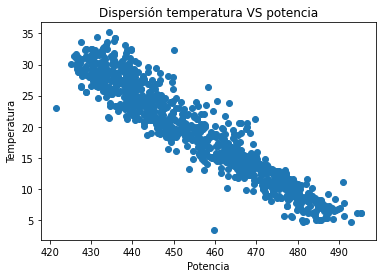

In [ ]:
# creamos un gráfico tipo scatterplot
plt.scatter(x = x_y_DF['PE'],
            y = x_y_DF['AT'])
plt.xlabel("Potencia")
plt.ylabel("Temperatura")
plt.title("Dispersión temperatura VS potencia")
plt.show()

### Ejercicio 3(b)

Repitiendo el proceso anterior, usa una sentencia SQL para crear un gráfico de dispersión entre las variables Power (PE) y Exhaust Vacuum Speed (V).

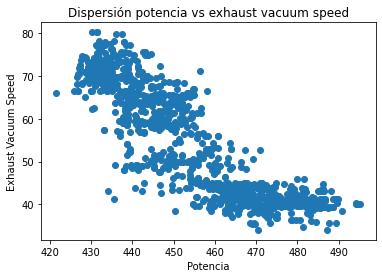

In [ ]:
x_y_vacuum=sqlContext.sql('SELECT PE, V FROM power_plant').orderBy(rand()).limit(1000).collect()
x_y_DF_vacuum = pd.DataFrame(x_y_vacuum, columns=['PE', 'V']);

plt.scatter(x=x_y_DF_vacuum['PE'], 
            y=x_y_DF_vacuum['V'])
plt.xlabel("Potencia")
plt.ylabel("Exhaust Vacuum Speed")
plt.title("Dispersión potencia vs exhaust vacuum speed")
#OPCIONES DE MATPLOTLIB - Titulo, x-y-label...
plt.show()

Ahora vamos a repetir este ejercicio con el resto de variables y la etiqueta Power Output.

### Ejercicio 3(c)

Usa una sentencia SQL para crear un gráfico de dispersión entre las variables Power (PE) y Pressure (AP).

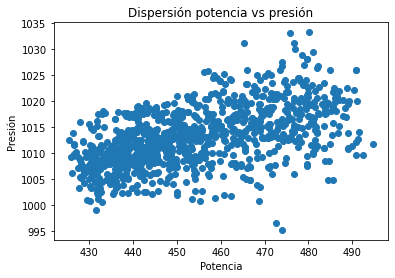

In [ ]:
x_y_pressure=sqlContext.sql('SELECT PE, AP FROM power_plant').orderBy(rand()).limit(1000).collect()
x_y_DF_pressure = pd.DataFrame(x_y_pressure, columns=['PE', 'AP']);

plt.scatter(x=x_y_DF_pressure['PE'], 
            y=x_y_DF_pressure['AP'])
plt.xlabel("Potencia")
plt.ylabel("Presión")
plt.title("Dispersión potencia vs presión")
#OPCIONES DE MATPLOTLIB - Titulo, x-y-label...
plt.show()

### Ejercicio 3(d)

Usa una sentencia SQL para crear un gráfico de dispersión entre las variables Power (PE) y Humidity (RH).

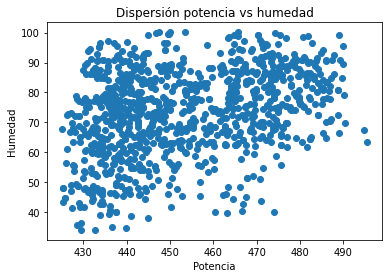

In [ ]:
x_y_humidity=sqlContext.sql('SELECT PE, RH FROM power_plant').orderBy(rand()).limit(1000).collect()
x_y_DF_humidity = pd.DataFrame(x_y_humidity, columns=['PE', 'RH']);

plt.scatter(x=x_y_DF_humidity['PE'], 
            y=x_y_DF_humidity['RH'])
plt.xlabel("Potencia")
plt.ylabel("Humedad")
plt.title("Dispersión potencia vs humedad")
#OPCIONES DE MATPLOTLIB - Titulo, x-y-label...
plt.show()

## Parte 4: Preparación de los datos

El siguiente paso es preparar los datos para aplicar la regresión. Dado que todo el dataset es numérico y consistente, esta será una tarea sencilla y directa.

El objetivo es utilizar el método de regresión para determinar una función que nos de la potencia de salida como una función de un conjunto de características de predicción. El primer paso en la construcción de nuestra regresión es convertir las características de predicción de nuestro DataFrame a un vector de características utilizando el método [pyspark.ml.feature.VectorAssembler()](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.VectorAssembler).

El VectorAssembler es una transformación que combina una lista dada de columnas en un único vector. Esta transformación es muy útil cuando queremos combinar características en crudo de los datos con otras generadas al aplicar diferentes funciones sobre los datos en un único vector de características. Para integrar en un único vector toda esta información antes de ejecutar un algoritmo de aprendizaje automático, el VectorAssembler toma una lista con los nombres de las columnas de entrada (lista de strings) y el nombre de la columna de salida (string).

============
### Ejercicio 4

- Leer la documentación y los ejemplos de uso de [VectorAssembler](https://spark.apache.org/docs/latest/ml-features.html#vectorassembler)
- Convertir la tabla SQL `power_plant` en un `dataset` llamado datasetDF
- Establecer las columnas de entrada del VectorAssember: `["AT", "V", "AP", "RH"]`
- Establecer la columnas de salida como `"features"`

En entorno **BATCH** podemos utilizar tanto Scikit-Learn con dataframe de Pandas o seguir con SparkML o MLlib (esta práctica utilizaremos ML de Spark).

NOTA: En **STREAMING**, siempre es aconsejable utilizar ML en streaming (Spark Streaming ML, Apache Mahout, MLflow...) mejor no utilizar scikit-Learn

In [ ]:
# creamos el dataset para vectorizarlo
from pyspark.ml.feature import VectorAssembler

datasetDF = sqlContext.table('power_plant')

vectorizer = VectorAssembler()

In [ ]:
# Creamos las columnas INPUT
vectorizer.setInputCols(['AT','V','AP','RH'])
vectorizer.setOutputCol('features')

VectorAssembler_34eac896581d

In [ ]:
# aplicamos el vectorizer al dataframe
vectorizer.transform(datasetDF).head().features

DenseVector([14.96, 41.76, 1024.07, 73.17])

## Parte 5: Modelar los datos

Ahora vamos a modelar nuestros datos para predecir que potencia de salida se dara cuando tenemos una serie de lecturas de los sensores

La API de [Apache Spark MLlib](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml) ofrece diferentes implementaciones de técnicas de regresion para modelar datasets. Ene ste ejercicio vamos a modelar nuestros datos para predecir que potencia de salida se dara cuando tenemos una serie de lecturas de los sensores basándonos en una simple regresion lineal ya que vimos algunos patrones lineales en nuestros datos en los graficos de dispersion durante la etapa de exploracion.

Necesitamos una forma de evaluar como de bien nuestro modelo de [regresion lineal](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression) predice la produccion de potencia en funcion de parametros de entrada. Podemos hacer esto mediante la division de nuestros datos iniciales establecidos en un _Training set_ utilizado para entrenar a nuestro modelo y un _Test set_ utilizado para evaluar el rendimiento de nuestro modelo. Podemos usar el metodo nativo de los DataFrames [randomSplit()](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.randomSplit) para dividir nuestro dataset. El metodo toma una lista de pesos y una semilla aleatoria opcional. La semilla se utiliza para inicializar el generador de numeros aleatorios utilizado por la funcion de division.

NOTA: Animamos a los alumnos a explorar las diferentes técnicas de regresión disponibles en la [API ML de Spark](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml.classification)

================================================================================
### Ejercicio 5(a)

Utiliza el método [randomSplit()](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.randomSplit) para dividir `datasetDF` en trainingSetDF (80% del DataFrame de entrada) y testSetDF (20% del DataFrame de entrada), para poder reproducir siempre el mismo resultado, usar la semilla 1800009193. Finalmente, cachea (cache()) cada datafrane en memoria para maximizar el rendimiento.

In [ ]:
=seed)

A continuacion vamos a crear un modelo de regresion lineal y utilizar su ayda para entender como entrenarlo. Ver la API de [Linear Regression](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression) para mas detalles.

### Ejercicio 5(b)

- Lee la documentacion y los ejemplos de [Linear Regression](https://spark.apache.org/docs/latest/ml-classification-regression.html#linear-regression)
- Ejecuta la siguiente celda

La siguiente celda esta basada en [Spark ML Pipeline API for Linear Regression](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression).

El primer paso es establecer los valores de los parametros siguientes:
- Define el nombre de la columna a donde guardaremos la prediccion como "Predicted_PE"
- Define el nombre de la columna que contiene la etiqueta como "PE"
- Define el numero maximo de iteraciones a 100
- Define el parametro de regularizacion a 0.1

Ahora, crearemos el [ML Pipeline](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.Pipeline) (flujo de ejecucion) y estableceremos las fases del pipeline como vectorizar y posteriormente aplicar el regresor lineal que hemos definido.

Finalmente, crearemos el modelo entrenandolo con el DataFrame `trainingSetDF`.

### Ejercicio 5(c)

- Lee la documentacion [Linear Regression](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression) documentation
- Completa y ejecuta la siguiente celda introduciendo los pará,etros descritos para nuestra regresion.

In [ ]:
0.1)

LinearRegression_76031609d751

Del articulo de Wikipedia [Linear Regression](https://en.wikipedia.org/wiki/Linear_regression) podemos leer:
> In statistics, linear regression is an approach for modeling the relationship between a scalar dependent variable \\( y \\) and one or more explanatory variables (or independent variables) denoted \\(X\\). In linear regression, the relationships are modeled using linear predictor functions whose unknown model parameters are estimated from the data. Such models are called linear models.

Los modelos de regresion lineal tienen muchos usos practicos. La mayoria de los cuales se clasifican en de las siguientes dos categorias:
- Si el objetivo es la prediccion o la reduccion de errores, la regresion lineal puede utilizarse para adaptar un modelo predictivo a un conjunto de datos observados \\(y\\) y \\(X\\). Despues de desarrollar un modelo de este tipo, dado un cierto valor  \\( X\\) del que no conocemos su valor de \\(y \\), el modelo ajustado se puede utilizarse para hacer una prediccion del valor del posible valor \\(y \\).
- Dada una variable \\(y\\) y un numero de variables \\( X_1 \\), ..., \\( X_p \\) que pueden estar relacionadas con \\(y\\), un analisis de regresion lineal puede ser aplicado a cuantificar como de fuerte es la relacion entre \\(y\\) y cada \\( X_j\\), para evaluar que \\( X_j \\) puede no tener ninguna relacion con \\(y\\), y de esta forma identificar que subconjuntos de \\( X_j \\) contienen informacion redundante sobre \\(y\\).

Como estamos interesados en ambos usos, nos gustaria para predecir la potencia de salida en funcion de las variables de entrada, y nos gustaria saber cuales de las variables de entrada estan debilmente o fuertemente correlacionadas con la potencia de salida.

Ya que una regresion lineal tan solo calcula la linea que minimiza el error cuadratico medio en el dataset de entrenamiento, dadas multiples dimensiones de entrada podemos expresar cada predictor como una funcion lineal en la forma:

\\[ y = a + b x_1 + b x_2 + b x_i ... \\]

donde \\(a\\) es el intercept (valor para el punto 0) y las \\(b\\) son los coeficientes.

Para expresar los coeficientes de esa linea podemos recuperar la etapa del Estimador del Modelo del pipeline y de expresar los pesos y el intercept de la funcion.

### Ejercicio 5(d)

Ejecuta la celda siguiente y asegurate que entiendes lo que sucede.

LinearRegressionModel: uid=LinearRegression_76031609d751, numFeatures=4

### PREGUNTA

- Que obtenemos como resultado de esta ejecución?

La ecuación devuelve nuestra observación meno el coeficiente positivo o negativo por cada uno de los atributos o variables indipendientes (predictores), cuanto más pequeños y se acerca a nuestra observación, el valor predicho es casi a cero, significa que la predicción se acerca a nuestra intercepta, cuando más lejano se encuentra (positivo o negativo), significa que el valor predicho se encuentra lejos a nivel de distancia de nuestra intercepta. Hay que examinar entre ellos los valores residuales, ya que valores muy ajustados produciría un **overfitting** y muy lejos **underfitting**.

***

### Ejercicio 5(e)

Ahora estudiaremos como se comportan nuestras predicciones en este modelo. Aplicamos nuestro modelo de regresion lineal para el 20% de los datos que hemos separado del conjunto de datos de entrada. La salida del modelo sera una columna de produccion de electricidad teorica llamada "Predicted_PE".

- Ejecuta la siguiente celda
- Desplazate por la tabla de resultados y observa como los valores de la columna de salida de corriente (PE) se comparan con los valores correspondientes en la salida de potencia predecida  (Predicted_PE)

In [ ]:
lDF)

DataFrame[AT: double, V: double, AP: double, RH: double, PE: double, Predicted_PE: double]

A partir de una inspección visual de las predicciones, podemos ver que están cerca de los valores reales.

Sin embargo, nos gustaría disponer de una medida científica exacta de la bondad del modelo. Para realizar esta medición, podemos utilizar una métrica de evaluación como la [Error cuadrático medio](https://en.wikipedia.org/wiki/Root-mean-square_deviation) (RMSE) para validar nuestro modelo.

RSME se define como: \\( RMSE = \sqrt{\frac{\sum_{i = 1}^{n} (x_i - y_i)^2}{n}}\\) donde \\(y_i\\) es el valor observado \\(x_i\\) es el valor predicho

RMSE es una medida muy habitual para calcular las diferencias entre los valores predichos por un modelo o un estimador y los valores realmente observados. Cuanto menor sea el RMSE, mejor será nuestro modelo.

Spark ML Pipeline proporciona diferentes métricas para evaluar modelos de regresión, incluyendo [RegressionEvaluator()](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator).

Después de crear una instancia de [RegressionEvaluator](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator), fijaremos el nombre de la columna objetivo "PE" y  el nombre de la columna de predicción a "Predicted_PE". A continuación, invocaremos el evaluador en las predicciones.

### Ejercicio 5(f)
Completa y ejecuta la celda siguiente:

In [ ]:
se"
)

Otra medida de evaluación estadística muy útil es el coeficiente de determinación, que se denota \\(R ^ 2 \\) o \\(r ^ 2\\) y pronunciado "R cuadrado". Es un número que indica la proporción de la variación en la variable dependiente que es predecible a partir de las variables independientes y proporciona una medida de lo bien que los resultados observados son replicados por el modelo, basado en la proporción de la variación total de los resultados explicada por el modelo. El coeficiente de determinación va de 0 a 1 (más cerca de 1), y cuanto mayor sea el valor, mejor es nuestro modelo.


Para calcular \\(r^2\\), hemos de ejecutar el evaluador `regEval.metricName: "r2"`

Vamos a calcularlo ejecutando la celda siguiente.

In [ ]:
2))

r2: 0.93


- Que resultado de \\(r^2\\) hemos obtenido? A partir de dicho parametro, crees que el modelo calculado se ajusta bien a los datos?

### RESPUESTA
El R2 indica la proporción de la varianza entre la variable dependiente y los atributos indipendientes. Al variar entre 0 y 1 cuanto más cercano esté al 1 es mejor, que corresponde al 100% es decir 1. En este caso tenemos 0.93, al parecer es un buen indicador.

***

***


En general, suponiendo una distribución Gaussiana de errores, un buen modelo tendrá 68% de las predicciones dentro de 1 RMSE y 95% dentro de 2 RMSE del valor real (ver http://statweb.stanford.edu/~susan/courses/s60/split/node60.html).

Vamos a examinar las predicciones y ver si un RMSE como el obtenido cumple este criterio.

Crearemos un nuevo DataFrame usando [selectExpr()](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.selectExpr) para generar un conjunto de expresiones SQL, y registrar el DataFrame como una tabla de SQL utilizando [registerTempTable()](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.registerTempTable).

### Ejercicio 5(g)

Ejecuta la celda siguiente y asegúrate que entiendes lo que sucede.

In [ ]:
on")

Podemos utilizar sentencias SQL para explorar la tabla `Power_Plant_RMSE_Evaluation`. En primer lugar vamos a ver qué datos en la tabla utilizando una sentencia SELECT de SQL.

Completa la siguiente consulta para que devuelva los elementos de la tabla `Power_Plant_RMSE_Evaluation` y muestra algunos por pantalla con la acción show().

## TAREA PARA CASA - parte 1

## Responde las siguientes preguntas
- ¿A partir de los resultados del ejercicio 5, te parece que el modelo ajusta bien los datos?
- ¿Qué otras técnicas de regresión usaríais a partir del análisis de datos del apartado 3? ¿Estan todas disponibles en Spark? ¿Y si no es el caso, qué otros librarias y herramientas de Machine Learning podriamos usar?



### Ejercicio 5(h)Mostrad el RMSE como un histograma.
https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.htmlPuedes jugar con los diferentes parámetros del histograma como el numero de 'bins' o el parámetro densidad, que cambia entre el 'contaje' de elementos en cada bin o la normalización para que el area del histograma sea 1.
De forma similar al ejercicio 3, toma una muestra aleatoria de 2000 elementos y haz un collect para hacer el plot.

In [ ]:
import numpy as np
df_x=sqlContext.sql(<FILL_IN>)

#MATPLOTLIB 
#LO PODÉIS MODIFICAR PARA QUE PODÁIS MOSTRAR LA DISTRIBUCIÓN EN HISTOGRAMA DE RSME
#ESTO ES SOLO UNA BASE, PERO HAY MANERAS DIFERENTES

x = pd.DataFrame(<FILL_IN>).to_numpy()

num_bins=<FILL_IN>

plt.hist(<FILL_IN>)
plt.show()

Observa que el histograma deberia mostrar claramente que el RMSE se centra alrededor de 0 con la gran mayoría de errores dentro de 2 RMSE.

Usando una instrucción SELECT de SQL un poco más compleja, podemos contar el número de predicciones dentro de + o - 1,0 y + o - 2,0.

Cuantas predicciones estan dentro de cada uno de los intervalos (+-1 RSME, +-2RSME y más allá)? Completad la parte de código que falta para poder averiguarlo.

- ¿Cuantas predicciones estan a 1 RMSE como máximo de los valores reales?
- ¿Y cuantas predicciones estan a 2 RMSE como máximo de los valores reales?

## Responde las siguientes preguntas
1. ¿A partir de los resultados del ejercicio 5, te parece que el modelo ajusta bien los datos?
2. ¿Qué otras técnicas de regresión usaríais a partir del análisis de datos del apartado 3? ¿Estan todas disponibles en Spark? ¿Y si no es el caso, qué otros librarias y herramientas de Machine Learning podriamos usar?
3. Investigad el modelo **LinearRegression** y observad los resultados al cambiar el resto de parámetros
4. Pueden ir investigando el resto de estimadores y observar y comparar los resultados